In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

from   sklearn.linear_model    import LinearRegression
from   sklearn.model_selection import train_test_split
from   sklearn.metrics         import mean_squared_error

warnings.filterwarnings('ignore')

In [2]:
import os
os.getcwd()

'/Users/chloebergsma-safar/Desktop/Metis/NBM_Regression_Project/Metis-Regression'

## Read in data

In [3]:
schools_1_400 = pd.read_csv('schools_csv_8.csv')

In [4]:
schools_401_800 = pd.read_csv('schools_csv_7.csv')

In [5]:
schools_801_1200 = pd.read_csv('schools_csv_6.csv')

In [6]:
schools_1201_1332 = pd.read_csv('schools_csv_5.csv')

## Concatenate dataframes

In [7]:
schools_df = pd.concat([schools_1_400, schools_401_800, schools_801_1200, schools_1201_1332], axis=0)

In [8]:
schools_df.shape

(1332, 37)

### Check concatenation

In [9]:
schools_401_800.shape

(400, 37)

In [10]:
schools_801_1200.shape

(400, 37)

In [11]:
schools_1201_1332.shape

(132, 37)

In [12]:
schools_df.shape

(1332, 37)

## Peform EDA on concatenated dataframe

In [13]:
schools_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1332 entries, 0 to 131
Data columns (total 37 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   school                                   1332 non-null   object 
 1   raw_stu_to_fac_ratio                     1323 non-null   object 
 2   tuition_fees                             1264 non-null   float64
 3   books_supplies                           1214 non-null   float64
 4   tuition                                  48 non-null     float64
 5   fees                                     48 non-null     float64
 6   tuition_under                            11 non-null     float64
 7   fees_under                               11 non-null     float64
 8   ft_faculty                               1316 non-null   float64
 9   pt_faculty                               1316 non-null   float64
 10  avg_amt_grant_schol_aid_beg_under_19_20  1281 non

### Clean tuition and fees columns

#### Consolidate tuition and tuition_under columns, since, based on webscraping, we know that they represent the same data stored in different places on school pages (thus, the decision to extract the data differently)

In [14]:
schools_df['tuition_20_21'] = np.nan

In [15]:
schools_df.tuition_20_21.fillna(schools_df.tuition, inplace=True)

In [16]:
schools_df.tuition_20_21.fillna(schools_df.tuition_under, inplace=True)

In [17]:
# check that in new col, where tuition has a value, it was assigned to the new col
tuition_not_nan = schools_df.loc[~schools_df.tuition.isna()]
tuition_not_nan[['tuition_20_21', 'tuition', 'tuition_under']].head()

,tuition_20_21,tuition,tuition_under
4,20370.0,20370.0,NaN
5,17820.0,17820.0,NaN
6,21600.0,21600.0,NaN
9,26820.0,26820.0,NaN
10,9375.0,9375.0,NaN


In [18]:
# check that in new col, where tuition_under has a value, it was assigned to the new col
tuition_under_not_nan = schools_df.loc[~schools_df.tuition_under.isna()]
tuition_under_not_nan[['tuition_20_21', 'tuition', 'tuition_under']].head()

,tuition_20_21,tuition,tuition_under
13,22230.0,NaN,22230.0
251,13440.0,NaN,13440.0
18,10440.0,NaN,10440.0
70,26400.0,NaN,26400.0
82,19975.0,NaN,19975.0


In [19]:
# drop tuition and tuition_under columns
#schools_df.drop(['tuition', 'tuition_under'],axis=1, inplace=True)

#### Consolidate fees and fees_under columns, since, based on webscraping, we know that they represent the same data stored in different places on school pages (thus, the decision to extract the data differently)

In [20]:
schools_df['fees_20_21'] = np.nan

In [21]:
schools_df.fees_20_21.fillna(schools_df.fees, inplace=True)

In [22]:
schools_df.fees_20_21.fillna(schools_df.fees_under, inplace=True)

In [23]:
# check that in new col, where fees has a value, it was assigned to the new col
fees_not_nan = schools_df.loc[~schools_df.fees.isna()]
fees_not_nan[['fees_20_21', 'fees', 'fees_under']].head()

,fees_20_21,fees,fees_under
4,300.0,300.0,NaN
5,300.0,300.0,NaN
6,435.0,435.0,NaN
9,75.0,75.0,NaN
10,600.0,600.0,NaN


In [24]:
# check that in new col, where fees_under has a value, it was assigned to the new col
fees_under_not_nan = schools_df.loc[~schools_df.fees_under.isna()]
fees_under_not_nan[['fees_20_21', 'fees', 'fees_under']].head()

,fees_20_21,fees,fees_under
13,1644.0,NaN,1644.0
251,0.0,NaN,0.0
18,60.0,NaN,60.0
70,900.0,NaN,900.0
82,2100.0,NaN,2100.0


In [25]:
# drop fees and fees_under columns
#schools_df.drop(['fees', 'fees_under'],axis=1, inplace=True)

#### Combine new tuition_20_21 and fees_20_21 columns

In [26]:
schools_df['tuition_fees_20_21'] = schools_df.tuition_20_21 + schools_df.fees_20_21

In [27]:
# check that in new col, where tuition_20_21 and fees_20_21 have values, the sum
    # was assigned to the new column
tuition_20_21_not_nan = schools_df.loc[~(schools_df.tuition_20_21.isna())]
tuition_20_21_not_nan[['tuition_fees_20_21', 'tuition_20_21', 'fees_20_21']].tail()

,tuition_fees_20_21,tuition_20_21,fees_20_21
79,78241.0,73200.0,5041.0
89,13386.0,12984.0,402.0
101,26200.0,26200.0,0.0
109,18000.0,18000.0,0.0
128,10625.0,10000.0,625.0


#### Consolidate tuition_fees_20_21 and tuition_fees columns since, based on webscraping, we know that they represent the same data stored in different places on school pages (thus, the decision to extract the data differently)

In [28]:
schools_df['tuition_fees_20_21_fin'] = np.nan

In [29]:
schools_df.tuition_fees_20_21_fin.fillna(schools_df.tuition_fees, inplace=True)

In [30]:
schools_df.tuition_fees_20_21_fin.fillna(schools_df.tuition_fees_20_21, inplace=True)

In [31]:
# check that in new col, where tuition_fees has a value, it was assigned to the new col
tuition_fees_not_nan = schools_df.loc[~schools_df.tuition_fees.isna()]
tuition_fees_not_nan[['tuition_fees_20_21_fin', 'tuition_fees_20_21', 'tuition_fees']].head()

,tuition_fees_20_21_fin,tuition_fees_20_21,tuition_fees
0,9700.0,NaN,9700.0
1,20760.0,NaN,20760.0
2,6250.0,NaN,6250.0
3,32404.0,NaN,32404.0
7,46486.0,NaN,46486.0


In [32]:
# check that in new col, where tuition_fees_20_21 has a value, it was assigned to the new col
tuition_fees_20_21_not_nan = schools_df.loc[~schools_df.tuition_fees_20_21.isna()]
tuition_fees_20_21_not_nan[['tuition_fees_20_21_fin', 'tuition_fees_20_21', 'tuition_fees']].head()

,tuition_fees_20_21_fin,tuition_fees_20_21,tuition_fees
4,20670.0,20670.0,NaN
5,18120.0,18120.0,NaN
6,22035.0,22035.0,NaN
9,26895.0,26895.0,NaN
10,9975.0,9975.0,NaN


In [33]:
# drop tuition_fees, tuition_fees_20_21, fees_20_21 and tuition_20_21 columns
#schools_df.drop(['tuition_fees', 'tuition_fees_20_21', 'fees_20_21', 'tuition_20_21'],axis=1, inplace=True)

#### Drop any rows with nan in tuition_fees_20_21_fin (our target variable for the linear regression)

In [34]:
schools_df.dropna(subset=['tuition_fees_20_21_fin'], inplace=True)

In [35]:
schools_df.shape # by dropping nan in tuition_fees_20_21_fin, we lost 9 rows

(1323, 41)

### Clean enrollment columns

In [36]:
schools_df[['school','total_enroll', 'total_enroll_under', 'under_enroll', 'under_trans_enroll', 'grad_enroll']].sample(10)

,school,total_enroll,total_enroll_under,under_enroll,under_trans_enroll,grad_enroll
222,Taylor University,2110.0,NaN,2076.0,27.0,34.0
305,Centre College,NaN,1333.0,NaN,7.0,NaN
100,Saint Anselm College,NaN,2019.0,NaN,20.0,NaN
34,Patrick Henry College,NaN,340.0,NaN,21.0,NaN
48,University of Mary,3799.0,NaN,2535.0,119.0,1264.0
33,Palm Beach Atlantic University,3704.0,NaN,2916.0,249.0,788.0
250,VanderCook College of Music,313.0,NaN,82.0,4.0,231.0
140,Cornish College of the Arts,NaN,482.0,NaN,41.0,NaN
300,Catawba College,1371.0,NaN,1340.0,89.0,31.0
380,Hastings College,982.0,NaN,956.0,42.0,26.0


In [37]:
schools_df['total_under_enroll'] = np.nan

In [38]:
schools_df['total_under_enroll'].fillna(schools_df.total_enroll_under, inplace=True)

In [39]:
schools_df['total_under_enroll'].fillna(schools_df.under_enroll, inplace=True)

In [40]:
# check that in new col, where total_enroll_under has a value, it was assigned to the new col
total_enroll_under_not_nan = schools_df.loc[~schools_df.total_enroll_under.isna()]
total_enroll_under_not_nan[['total_under_enroll', 'total_enroll_under', 'under_enroll']].sample(5)

,total_under_enroll,total_enroll_under,under_enroll
124,135.0,135.0,NaN
148,565.0,565.0,NaN
140,1451.0,1451.0,NaN
277,232.0,232.0,NaN
330,1822.0,1822.0,NaN


In [41]:
# check that in new col, where under_enroll has a value, it was assigned to the new col
under_enroll_not_nan = schools_df.loc[~schools_df.under_enroll.isna()]
under_enroll_not_nan[['total_under_enroll', 'total_enroll_under', 'under_enroll']].sample(5)

,total_under_enroll,total_enroll_under,under_enroll
108,137.0,NaN,137.0
102,100.0,NaN,100.0
45,152.0,NaN,152.0
67,1318.0,NaN,1318.0
265,1071.0,NaN,1071.0


In [42]:
# drop total_enroll_under and under_enroll columns
#schools_df.drop(['total_enroll_under', 'under_enroll'],axis=1, inplace=True)

In [43]:
# drop total_enroll (i.e., the sum of under_enroll, under_trans_enroll, and grad_enroll, 
    # since not enough schools have grad programs to consider info about them 
#schools_df.drop(['total_enroll', 'grad_enroll'], axis=1, inplace=True)

#### Investigate the 5 schools with nan in new total_under_enroll column and the under_trans_enroll column

In [44]:
total_under_enroll_nan = schools_df.loc[(schools_df.total_under_enroll.isna()) & (schools_df.under_trans_enroll.isna())]
total_under_enroll_nan[['school', 'total_under_enroll', 'under_trans_enroll']]

,school,total_under_enroll,under_trans_enroll
24,Montana Bible College,NaN,NaN
257,Zaytuna College,NaN,NaN
308,Southwest University of Visual Arts-Tucson,NaN,NaN
341,Faith Theological Seminary and Christian College,NaN,NaN
255,Maple Springs Baptist Bible College and Seminary,NaN,NaN


- Montana Bible College: according to NCES website, "Data not available."
- Zaytuna College: " "
- Southwest University of Visual Arts-Tucson: " "
- Faith Theological Seminary and Christian College: " "
- Maple Springs Baptist Bible College and Seminary: according to NCES website, "School failed to provide data and is subject to administrative action, including a fine or termination of eligibility to participate in federal student aid."

In [45]:
# look at other columns for these schools to see if they are worth keeping in for other 
    # info besides enrollment data
#total_under_enroll_nan.iloc[:,:15]

In [46]:
#total_under_enroll_nan.iloc[:,15:]

In [47]:
# drop Zaytuna College, Southwest University of Visual Arts-Tucson, and 
    # Faith Theological Seminary and Christian College, since the only feature for which
    # they have data is the price of books and supplies in 20-21
#schools_drop_no_enroll_data = ['Zaytuna College', 'Southwest University of Visual Arts-Tucson',
                             # 'Faith Theological Seminary and Christian College']
#schools_df = schools_df[schools_df.school.isin(schools_drop_no_enroll_data) == False]

#### Look at summary statistics of total_under_enroll column and its distribution to determine what values to assign the other two schools with missing datda in the total_under_enroll column

In [48]:
schools_df[['total_under_enroll']].describe()

,total_under_enroll
count,1318.000000
mean,2055.184370
std,5229.104645
min,2.000000
25%,365.000000
50%,1107.000000
75%,2160.500000
max,111599.000000


<AxesSubplot:xlabel='total_under_enroll', ylabel='Count'>

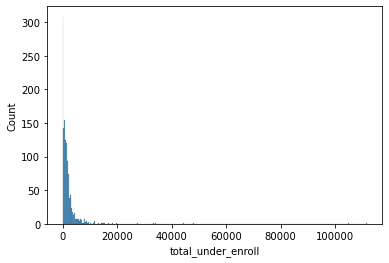

In [49]:
sns.histplot(schools_df.total_under_enroll)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='total_under_enroll'>

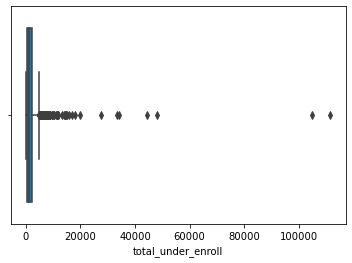

In [50]:
sns.boxplot(schools_df.total_under_enroll)

#### Since there are many outliers in the total_under_enroll column, assign the median of that column to the five schools missing data in that column

In [51]:
total_under_enroll_med = schools_df['total_under_enroll'].median()
schools_df.total_under_enroll.fillna(total_under_enroll_med, inplace=True)

In [52]:
schools_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1323 entries, 0 to 131
Data columns (total 42 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   school                                   1323 non-null   object 
 1   raw_stu_to_fac_ratio                     1318 non-null   object 
 2   tuition_fees                             1264 non-null   float64
 3   books_supplies                           1211 non-null   float64
 4   tuition                                  48 non-null     float64
 5   fees                                     48 non-null     float64
 6   tuition_under                            11 non-null     float64
 7   fees_under                               11 non-null     float64
 8   ft_faculty                               1309 non-null   float64
 9   pt_faculty                               1309 non-null   float64
 10  avg_amt_grant_schol_aid_beg_under_19_20  1276 non

### Clean student-to-faculty ratio column

In [53]:
# look at values in raw_stu_to_fac_ratio
schools_df['raw_stu_to_fac_ratio'].value_counts()

12 to 1                                                                                                                                                                                                                                   168
11 to 1                                                                                                                                                                                                                                   152
10 to 1                                                                                                                                                                                                                                   135
13 to 1                                                                                                                                                                                                                                   127
14 to 1                                         

In [54]:
# look at unique values in raw_stu_to_fac_ratio column to see if there's extra white space
schools_df['raw_stu_to_fac_ratio'].unique()

array(['6 to 1', '8 to 1', '4 to 1', '5 to 1', '7 to 1', '3 to 1',
       '10 to 1', '11 to 1', '9 to 1', '14 to 1', '2 to 1', '16 to 1',
       '21 to 1', '20 to 1', '15 to 1', '33 to 1', nan, '12 to 1',
       '18 to 1', '13 to 1', '26 to 1', '19 to 1', '22 to 1', '23 to 1',
       '17 to 1', '1 to 1',
       '3 to 1View noteThe institution had a significant decrease in enrollment for the 2020-21 year, while retaining its full-time faculty.',
       "13 to 1View noteDue to the COVID-19 pandemic, USD's undergraduate enrollment for Fall 2020 was lower than in previous fall terms resulting in a lower student-to-faculty ratio.",
       '42 to 1', '28 to 1',
       '4 to 1View notePlease interpret these data in the context of the COVID-19 pandemic, which has created some anomalies and fluctuations in enrollment and related statistics.',
       '25 to 1', '31 to 1', '30 to 1', '40 to 1', '35 to 1', '27 to 1',
       '12 to 1View noteThe reduction in the student faculty ratio is directly re

In [55]:
# create a list containing the str value in the column raw_stu_to_fac_ratio
stu_to_fac_ratio_ls = [row for row in schools_df['raw_stu_to_fac_ratio'].astype(str)]

In [56]:
# split each str value in the list into a list, so there are inner lists, one per str
stu_to_fac_ratio_ls = [ele.split(' ') for ele in stu_to_fac_ratio_ls]

In [57]:
print(stu_to_fac_ratio_ls[0])
print(stu_to_fac_ratio_ls[0][2][0])

['6', 'to', '1']
1


In [58]:
for lst in stu_to_fac_ratio_ls:
    if len(lst) == 1:
        print(lst)

['nan']
['nan']
['nan']
['nan']
['nan']


In [59]:
# create a list that keeps just the first three elements in each inner list
stu_to_fac_ratio_ls_rev = [ls[:3] for ls in stu_to_fac_ratio_ls] 

In [60]:
for lst in stu_to_fac_ratio_ls_rev:
    if len(lst) == 1:
        print(lst)

['nan']
['nan']
['nan']
['nan']
['nan']


In [61]:
# loop through the new list to find the indices of the inner lists whose third element
    # is of length greater than one

indices = []

for i in range(0, len(stu_to_fac_ratio_ls_rev)):
    if len(stu_to_fac_ratio_ls_rev[i]) > 1:
        if len(stu_to_fac_ratio_ls_rev[i][2]) > 1:
            indices.append(i)

In [62]:
# print out the lists whose third element is of length greater than one

for i in indices:
    print(stu_to_fac_ratio_ls_rev[i])

['3', 'to', '1View']
['13', 'to', '1View']
['4', 'to', '1View']
['12', 'to', '1View']
['21', 'to', '1View']


In [63]:
# create a final list that fixes inner lists whose third element has 'View' in it

stu_to_fac_ratio_ls_rev_2 = []

for i in range(0, len(stu_to_fac_ratio_ls_rev)):
    if i in indices:
        first_char = stu_to_fac_ratio_ls_rev[i][0]
        second_char = stu_to_fac_ratio_ls_rev[i][1]
        third_char = stu_to_fac_ratio_ls_rev[i][2].replace('1View','1')
        stu_to_fac_ratio_ls_rev_2.append([first_char, second_char, third_char])
    else:
        stu_to_fac_ratio_ls_rev_2.append(stu_to_fac_ratio_ls_rev[i])

In [64]:
# delete elements in each inner list that are the word 'to'

for ele in stu_to_fac_ratio_ls_rev_2:
    if len(ele) > 1:
        del ele[1]

In [65]:
# replace inner lists that are ['nan'] with ['0', '1'] so that next the elements in every
    # inner list can be converted to integers and math can be done on them

stu_to_fac_ratio_ls_rev_3 = []

for ele in stu_to_fac_ratio_ls_rev_2:
    if len(ele) <= 1:
        new_ele = ele[0].replace("nan", "0")
        second_new_ele = '1'
        stu_to_fac_ratio_ls_rev_3.append([new_ele, second_new_ele])
    else:
        stu_to_fac_ratio_ls_rev_3.append(ele)

In [66]:
# convert elements in inner lists to type integer

stu_to_fac_ratio_ls_rev_3 = [[int(x) for x in lst] for lst in stu_to_fac_ratio_ls_rev_3]

In [67]:
# create a new list of innenr lists that each contian the result of the first element
    # divided by the second element of each inner list

stu_to_fac_ratio_ls_rev_4 = [[lst[0] / lst[1]] for lst in stu_to_fac_ratio_ls_rev_3]

In [68]:
# flatten the above list so each new float value isn't in its own list

flattened_stu_to_fac_ratio = [item for sublist in stu_to_fac_ratio_ls_rev_4 for item in sublist]

In [69]:
# add cleaned student-to-faculty ratio list back to df

schools_df['stu_to_fac_ratio'] = flattened_stu_to_fac_ratio

#### Look at summary statistics and distribution of new student-to-faculty ratio column

<AxesSubplot:xlabel='stu_to_fac_ratio', ylabel='Count'>

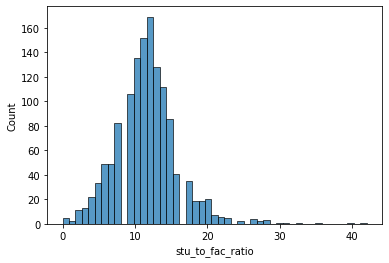

In [70]:
sns.histplot(schools_df['stu_to_fac_ratio'])

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='stu_to_fac_ratio'>

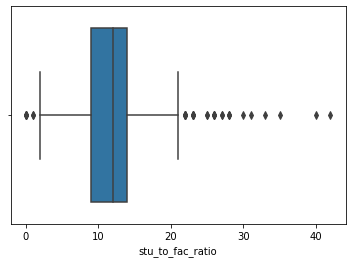

In [71]:
sns.boxplot(schools_df['stu_to_fac_ratio'])

In [72]:
schools_df['stu_to_fac_ratio'].describe()

count    1323.000000
mean       11.629630
std         4.360159
min         0.000000
25%         9.000000
50%        12.000000
75%        14.000000
max        42.000000
Name: stu_to_fac_ratio, dtype: float64

#### Replace rows missing data in this column with the median of the column

In [73]:
stu_to_fac_ratio_med = schools_df['stu_to_fac_ratio'].median()
schools_df.stu_to_fac_ratio.fillna(stu_to_fac_ratio_med, inplace=True)

In [74]:
schools_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1323 entries, 0 to 131
Data columns (total 43 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   school                                   1323 non-null   object 
 1   raw_stu_to_fac_ratio                     1318 non-null   object 
 2   tuition_fees                             1264 non-null   float64
 3   books_supplies                           1211 non-null   float64
 4   tuition                                  48 non-null     float64
 5   fees                                     48 non-null     float64
 6   tuition_under                            11 non-null     float64
 7   fees_under                               11 non-null     float64
 8   ft_faculty                               1309 non-null   float64
 9   pt_faculty                               1309 non-null   float64
 10  avg_amt_grant_schol_aid_beg_under_19_20  1276 non

In [75]:
# drop the rows with 0 in the new stu_to_fac_ratio column, since those were missing values
    # in the original student-to-faculty ratio column
#schools_df = schools_df.loc[schools_df.stu_to_fac_ratio != 0]

In [76]:
# drop raw_stu_to_fac_ratio column from dataframe
#schools_df.drop(['raw_stu_to_fac_ratio'],axis=1,inplace=True)

### Clean books and supplies columns

#### Look at spread of books_supplies column

<AxesSubplot:xlabel='books_supplies', ylabel='Count'>

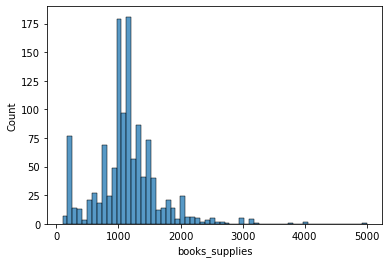

In [77]:
sns.histplot(schools_df.books_supplies)

In [78]:
schools_df[['books_supplies']].describe()

,books_supplies
count,1211.000000
mean,1146.397192
std,516.229418
min,100.000000
25%,921.000000
50%,1144.000000
75%,1344.000000
max,5000.000000


#### Since the mean and median are almost exactly the same, it seems like I can pick either value to impute the value of this variable for schools with missing data; I'll use median.

In [79]:
books_supplies_med = schools_df['books_supplies'].median()
schools_df.books_supplies.fillna(books_supplies_med, inplace=True)

In [80]:
schools_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1323 entries, 0 to 131
Data columns (total 43 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   school                                   1323 non-null   object 
 1   raw_stu_to_fac_ratio                     1318 non-null   object 
 2   tuition_fees                             1264 non-null   float64
 3   books_supplies                           1323 non-null   float64
 4   tuition                                  48 non-null     float64
 5   fees                                     48 non-null     float64
 6   tuition_under                            11 non-null     float64
 7   fees_under                               11 non-null     float64
 8   ft_faculty                               1309 non-null   float64
 9   pt_faculty                               1309 non-null   float64
 10  avg_amt_grant_schol_aid_beg_under_19_20  1276 non

### Clean faculty columns

#### Look at spread of each column

In [81]:
schools_df[['ft_faculty', 'pt_faculty']].describe()

,ft_faculty,pt_faculty
count,1309.000000,1309.000000
mean,191.766998,145.064935
std,585.064756,301.882032
min,0.000000,0.000000
25%,23.000000,21.000000
50%,69.000000,64.000000
75%,149.000000,159.000000
max,6927.000000,6340.000000


<AxesSubplot:xlabel='ft_faculty', ylabel='Count'>

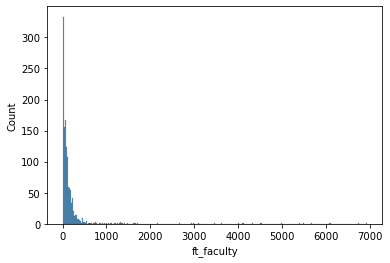

In [82]:
sns.histplot(schools_df['ft_faculty'])

<AxesSubplot:xlabel='pt_faculty', ylabel='Count'>

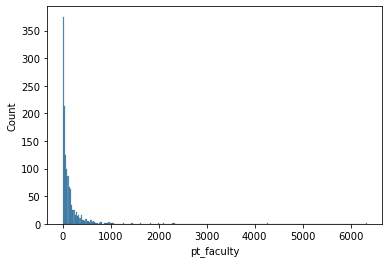

In [83]:
sns.histplot(schools_df['pt_faculty'])

#### Since the distribution of both columns is right-skewed, I will use the medians to impute them for schools missing this data.

In [84]:
ft_faculty_med = schools_df['ft_faculty'].median()
schools_df.ft_faculty.fillna(ft_faculty_med, inplace=True)

In [85]:
pt_faculty_med = schools_df['pt_faculty'].median()
schools_df.pt_faculty.fillna(pt_faculty_med, inplace=True)

### Clean applications apps

#### Look at schools missing number of undergraduate applications

In [86]:
# there are 237 schools missing data in this column
len(schools_df.loc[schools_df['under_apps'].isna()])

237

In [87]:
# I'll randomly research 23 of them on NCES' website

under_apps_nan = schools_df.loc[schools_df['under_apps'].isna()]
under_apps_nan[['school']].sample(23)

,school
137,Columbia College Hollywood
254,Walsh College
293,Ottawa University-Phoenix
373,Huntsville Bible College
40,California College San Diego-CollegeAmerica-Ph...
35,Austin Graduate School of Theology
259,Stevens-Henager College
301,Remington College-Fort Worth Campus
367,Drury University-College of Continuing Profess...
110,University of Fort Lauderdale


#### Of the 23 schools I randomly sampled who didn't have undergraduate application data:
    - 6 (~26%) stated it's because they don't admit full-time first-time degree/certificate-seeking students
    - 16 (~70%) stated it's because they have an open admission policy
    - 1 (!4%) stated it's because they're not required to provide admissions or test score data

- Samuel Merritt University: 'This institution does not admit full-time first-time degree/certificate-seeking students, therefore admission information was not reported.'
- Atlantic Institute of Oriental Medicine: " "
- Oak Point University: " "
- Touro University Nevada: " "
- Sentara College of Health Sciences: " "
- Rush University: " "
- Parker University: 'This institution has an open admission policy. Contact the institution for more information.'
- Virginia University of Lynchburg: " "
- Walla Walla University: " "
- Martin University: " "
- Bethlehem College & Seminary: " "
- Beulah Heights University: " "
- Jarvis Christian College: " "
- Pittsburgh Technical College: " "
- Talmudic College of Florida: '" "
- Rabbinical College Ohr Yisroel: " "
- Remington College-Shreveport Campus: " "
- Ohio Christian University: " "
- Yeshiva Yesoda Hatorah Vetz Chaim: " "
- Faith International University: " "
- Miles College: " "
- Lincoln University: " "
- Central Yeshiva Beth Joseph: "This institution was not required to provide admissions or test score data."

#### Create new column to code for the presence or absence of admissions data. The absence represents those who likely have an open admissions policy or don't admit full-time first-time degree/certificate seeking students.

In [88]:
# add column that indicates presence or absence of admissions data on NCES school page
schools_df['admiss_data'] = schools_df.under_apps.map(lambda x: 1 if not np.isnan(x) else 0)

In [89]:
# check new column
schools_df['admiss_data'].value_counts()

1    1086
0     237
Name: admiss_data, dtype: int64

#### Look at spread of under_apps and perc_admitted

In [90]:
schools_df[['under_apps', 'perc_admitted']].describe()

,under_apps,perc_admitted
count,1086.000000,1086.000000
mean,4439.233886,68.193370
std,7860.829967,21.779655
min,1.000000,0.000000
25%,576.250000,57.000000
50%,2016.500000,72.000000
75%,4710.500000,83.000000
max,80210.000000,100.000000


<AxesSubplot:xlabel='under_apps', ylabel='Count'>

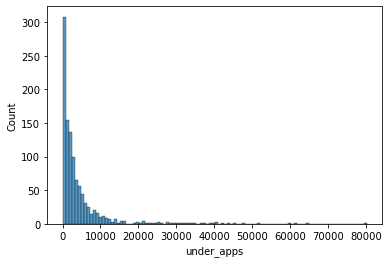

In [91]:
sns.histplot(schools_df.under_apps)

<AxesSubplot:xlabel='perc_admitted', ylabel='Count'>

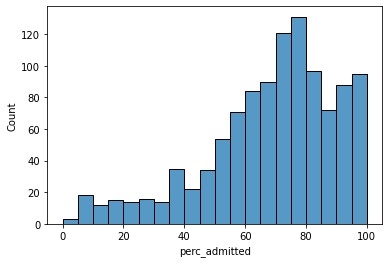

In [92]:
sns.histplot(schools_df.perc_admitted)

#### Since under_apps column is right-skewed, inpute the median for the schools with missing data in the under_apps column. For the perc_admitted column, impute 100%, since most of the schools I sampled who are missing admissions data have open admissions, so the argument could be made that they admit 100% of those who apply.

In [93]:
under_apps_med = schools_df.under_apps.median()
schools_df.under_apps.fillna(under_apps_med, inplace=True)

In [94]:
schools_df.perc_admitted.fillna(100.0, inplace=True)

### Clean financial aid columns

#### Investigate the NCES pages of the 10 schools missing average amount of grant or scholarship aid received by undergrad students in 2019-20

In [95]:
schools_df.loc[schools_df.avg_amt_grant_schol_aid_all_under_19_20.isna()]

,school,raw_stu_to_fac_ratio,tuition_fees,books_supplies,tuition,fees,tuition_under,fees_under,ft_faculty,pt_faculty,...,act_eng_75_perc,act_math_25_perc,act_math_75_perc,tuition_20_21,fees_20_21,tuition_fees_20_21,tuition_fees_20_21_fin,total_under_enroll,stu_to_fac_ratio,admiss_data
183,Northwestern Polytechnic University,2 to 1,8720.0,1210.0,NaN,NaN,NaN,NaN,4.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,8720.0,6.0,2.0,1
193,Pacific States University,5 to 1,12960.0,1687.0,NaN,NaN,NaN,NaN,2.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,12960.0,2.0,5.0,0
257,Zaytuna College,NaN,19250.0,200.0,NaN,NaN,NaN,NaN,69.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,19250.0,1107.0,0.0,0
308,Southwest University of Visual Arts-Tucson,NaN,23069.0,1038.0,NaN,NaN,NaN,NaN,69.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,23069.0,1107.0,0.0,0
264,Atlantic Institute of Oriental Medicine,6 to 1,NaN,1144.0,17000.0,595.0,NaN,NaN,6.0,0.0,...,NaN,NaN,NaN,17000.0,595.0,17595.0,17595.0,69.0,6.0,0
340,Fairfax University of America,4 to 1,10328.0,1200.0,NaN,NaN,NaN,NaN,10.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10328.0,17.0,4.0,0
341,Faith Theological Seminary and Christian College,NaN,1520.0,300.0,NaN,NaN,NaN,NaN,69.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1520.0,1107.0,0.0,0
126,W L Bonner College,3 to 1,NaN,1144.0,NaN,NaN,5148.0,268.0,1.0,5.0,...,NaN,NaN,NaN,5148.0,268.0,5416.0,5416.0,21.0,3.0,0
213,Gratz College,12 to 1,NaN,1144.0,19648.0,985.0,NaN,NaN,4.0,25.0,...,NaN,NaN,NaN,19648.0,985.0,20633.0,20633.0,159.0,12.0,0
62,Hebrew College,1 to 1,NaN,1144.0,29760.0,240.0,NaN,NaN,9.0,31.0,...,NaN,NaN,NaN,29760.0,240.0,30000.0,30000.0,26.0,1.0,0


- Northwestern Polytechnic University: $0 in total amount of aid received column
- Pacific States University: " "
- Atlantic Institute of Oriental Medicine: " "
- Fairfax University of America: 'Average amounts are withheld to preserve the confidentiality of individuals.' (17 undergrad students)
- Gratz College: " " (159 undergrad students)
- Hebrew College: " " (26 undergrad students)
- W L Bonner College: "Data not available."
- Zaytuna College: " "
- Southwest University of Visual Arts-Tucson: " "
- Faith Theological Seminary and Christian College: " "

#### Look at spread of this column

In [96]:
schools_df[['avg_amt_grant_schol_aid_all_under_19_20']].describe()

,avg_amt_grant_schol_aid_all_under_19_20
count,1313.000000
mean,17922.451637
std,10983.320842
min,582.000000
25%,8503.000000
50%,16836.000000
75%,24463.000000
max,58244.000000


<AxesSubplot:xlabel='avg_amt_grant_schol_aid_all_under_19_20', ylabel='Count'>

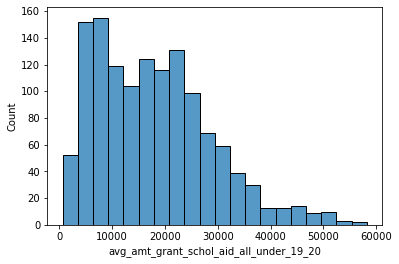

In [97]:
sns.histplot(schools_df.avg_amt_grant_schol_aid_all_under_19_20)

#### Assign '0' to the three schools with $0 under 'Total amount of aid received'; impute the median average amount of aid for the other seven schools missing values in this column.

In [98]:
schools_zero_aid = ['Northwestern Polytechnic University', 'Pacific States University',
                   'Atlantic Institute of Oriental Medicine']
schools_df.loc[schools_df.school.isin(schools_zero_aid),['avg_amt_grant_schol_aid_all_under_19_20']] = 0

In [99]:
schools_med_aid = ['Fairfax University of America', 'Gratz College','Hebrew College','W L Bonner College',
                  'Zaytuna College', 'Faith Theological Seminary and Christian College', 'Southwest University of Visual Arts-Tucson']
avg_amt_grant_schol_aid_all_under_19_20_med = schools_df['avg_amt_grant_schol_aid_all_under_19_20'].median()
schools_df.loc[schools_df.school.isin(schools_med_aid),['avg_amt_grant_schol_aid_all_under_19_20']] = avg_amt_grant_schol_aid_all_under_19_20_med

In [100]:
schools_df.loc[schools_df.school.isin(schools_med_aid)]

,school,raw_stu_to_fac_ratio,tuition_fees,books_supplies,tuition,fees,tuition_under,fees_under,ft_faculty,pt_faculty,...,act_eng_75_perc,act_math_25_perc,act_math_75_perc,tuition_20_21,fees_20_21,tuition_fees_20_21,tuition_fees_20_21_fin,total_under_enroll,stu_to_fac_ratio,admiss_data
257,Zaytuna College,NaN,19250.0,200.0,NaN,NaN,NaN,NaN,69.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,19250.0,1107.0,0.0,0
308,Southwest University of Visual Arts-Tucson,NaN,23069.0,1038.0,NaN,NaN,NaN,NaN,69.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,23069.0,1107.0,0.0,0
340,Fairfax University of America,4 to 1,10328.0,1200.0,NaN,NaN,NaN,NaN,10.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,10328.0,17.0,4.0,0
341,Faith Theological Seminary and Christian College,NaN,1520.0,300.0,NaN,NaN,NaN,NaN,69.0,64.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1520.0,1107.0,0.0,0
126,W L Bonner College,3 to 1,NaN,1144.0,NaN,NaN,5148.0,268.0,1.0,5.0,...,NaN,NaN,NaN,5148.0,268.0,5416.0,5416.0,21.0,3.0,0
213,Gratz College,12 to 1,NaN,1144.0,19648.0,985.0,NaN,NaN,4.0,25.0,...,NaN,NaN,NaN,19648.0,985.0,20633.0,20633.0,159.0,12.0,0
62,Hebrew College,1 to 1,NaN,1144.0,29760.0,240.0,NaN,NaN,9.0,31.0,...,NaN,NaN,NaN,29760.0,240.0,30000.0,30000.0,26.0,1.0,0


In [101]:
# drop avg_amt_grant_schol_aid_beg_under_19_20 since it's messy because of the way the data was scraped, 
    # some values in avg_amt_grant_schol_aid_beg_under_19_20 are actually avg_amt_grant_schol_aid_all_under_19_20
schools_df.drop(['avg_amt_grant_schol_aid_beg_under_19_20'],axis=1, inplace=True)

In [102]:
schools_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1323 entries, 0 to 131
Data columns (total 43 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   school                                   1323 non-null   object 
 1   raw_stu_to_fac_ratio                     1318 non-null   object 
 2   tuition_fees                             1264 non-null   float64
 3   books_supplies                           1323 non-null   float64
 4   tuition                                  48 non-null     float64
 5   fees                                     48 non-null     float64
 6   tuition_under                            11 non-null     float64
 7   fees_under                               11 non-null     float64
 8   ft_faculty                               1323 non-null   float64
 9   pt_faculty                               1323 non-null   float64
 10  avg_amt_grant_schol_aid_all_under_19_20  1323 non

### Clean test score columns

#### Replace nans in test_scores_admiss_con, test_scores_req, test_scores_rec, and test_scores_con_not_req with 0

In [103]:
subset = ['test_scores_admiss_con', 'test_scores_req', 'test_scores_rec', 
            'test_scores_con_not_req']

for col in subset:
    schools_df[col]=schools_df[col].fillna(0)

#### Create dummy variables out of the columns with 0s and 1s in them

In [104]:
schools_df_dummies = pd.get_dummies(schools_df,columns=['admiss_data','test_scores_admiss_con', 'test_scores_req', 
                                                        'test_scores_rec', 'test_scores_con_not_req'])

In [105]:
schools_df_dummies.tail()

,school,raw_stu_to_fac_ratio,tuition_fees,books_supplies,tuition,fees,tuition_under,fees_under,ft_faculty,pt_faculty,...,admiss_data_0,admiss_data_1,test_scores_admiss_con_0.0,test_scores_admiss_con_1.0,test_scores_req_0.0,test_scores_req_1.0,test_scores_rec_0.0,test_scores_rec_1.0,test_scores_con_not_req_0.0,test_scores_con_not_req_1.0
127,Wheaton College (Massachusetts),11 to 1,56366.0,940.0,NaN,NaN,NaN,NaN,120.0,59.0,...,0,1,0,1,1,0,1,0,0,1
128,William James College,7 to 1,NaN,1144.0,10000.0,625.0,NaN,NaN,73.0,50.0,...,1,0,1,0,1,0,1,0,1,0
129,Williams College,6 to 1,50450.0,800.0,NaN,NaN,NaN,NaN,317.0,69.0,...,0,1,1,0,1,0,1,0,1,0
130,Worcester Polytechnic Institute,13 to 1,54416.0,1200.0,NaN,NaN,NaN,NaN,446.0,77.0,...,0,1,1,0,1,0,1,0,1,0
131,Yale University,4 to 1,57700.0,1000.0,NaN,NaN,NaN,NaN,5393.0,972.0,...,0,1,0,1,1,0,1,0,0,1


In [106]:
schools_df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1323 entries, 0 to 131
Data columns (total 48 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   school                                   1323 non-null   object 
 1   raw_stu_to_fac_ratio                     1318 non-null   object 
 2   tuition_fees                             1264 non-null   float64
 3   books_supplies                           1323 non-null   float64
 4   tuition                                  48 non-null     float64
 5   fees                                     48 non-null     float64
 6   tuition_under                            11 non-null     float64
 7   fees_under                               11 non-null     float64
 8   ft_faculty                               1323 non-null   float64
 9   pt_faculty                               1323 non-null   float64
 10  avg_amt_grant_schol_aid_all_under_19_20  1323 non

In [107]:
len(schools_df_dummies.columns)

48

## Create new dataframe that doesn't contain columns not needed for analysis

In [110]:
schools_df_rev = schools_df_dummies[['tuition_fees_20_21_fin','stu_to_fac_ratio','ft_faculty',
                                     'pt_faculty','books_supplies','avg_amt_grant_schol_aid_all_under_19_20',
                                     'total_under_enroll','admiss_data_1', 'admiss_data_0','under_apps',
                                     'perc_admitted','test_scores_req_0.0','test_scores_req_1.0',
                                     'test_scores_rec_0.0', 'test_scores_rec_1.0','test_scores_con_not_req_0.0',
                                     'test_scores_con_not_req_1.0']]

In [125]:
schools_df_rev.columns

Index(['tuition_fees', 'stu_to_fac_ratio', 'ft_faculty', 'pt_faculty',
       'books_supplies', 'avg_grant_schol_aid', 'total_under_enroll',
       'admiss_data_1', 'admiss_data_0', 'under_apps', 'perc_admitted',
       'test_scores_req_0.0', 'test_scores_req_1.0', 'test_scores_rec_0.0',
       'test_scores_rec_1.0', 'test_scores_con_not_req_0.0',
       'test_scores_con_not_req_1.0'],
      dtype='object')

In [124]:
# rename some columns
schools_df_rev.rename(columns={'tuition_fees_20_21_fin':'tuition_fees', 
                               'avg_amt_grant_schol_aid_all_under_19_20':'avg_grant_schol_aid'},inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


#### Create pairplot of target variable and all feature variables

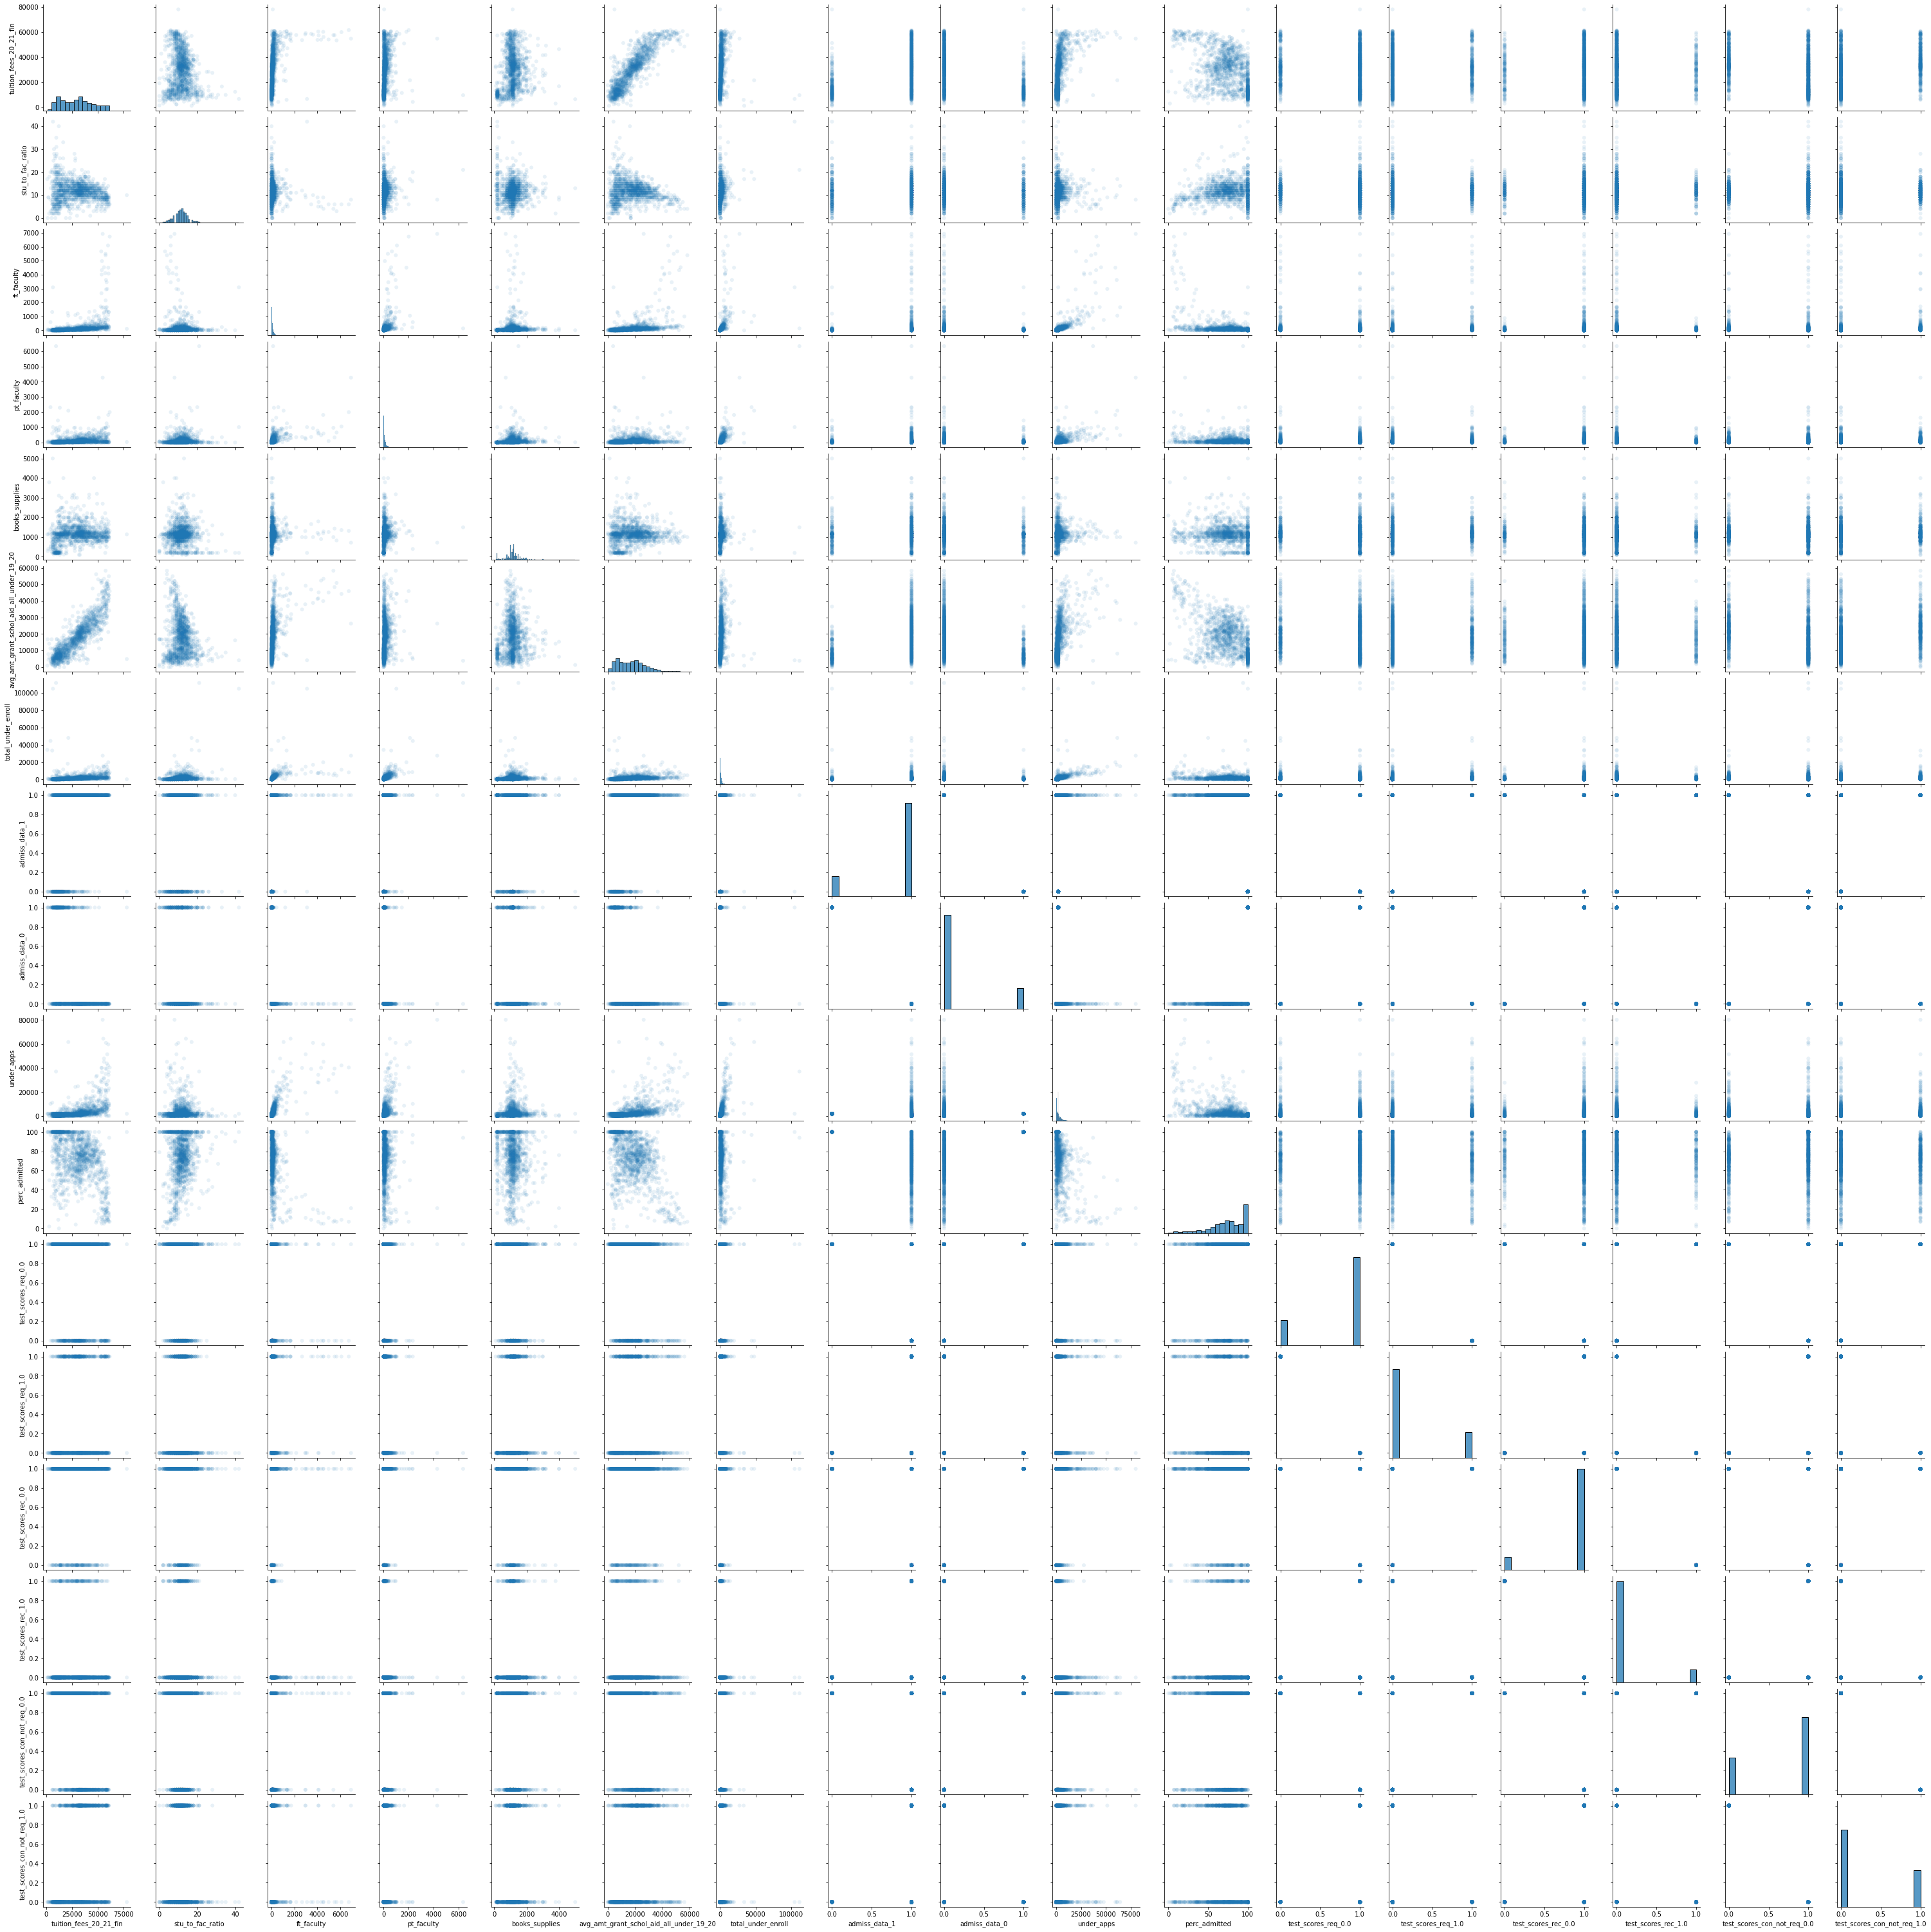

In [123]:
sns.pairplot(schools_df_rev, plot_kws=dict(alpha=.1, edgecolor='none'))

#### Create pairplots of target variable and continuous variables

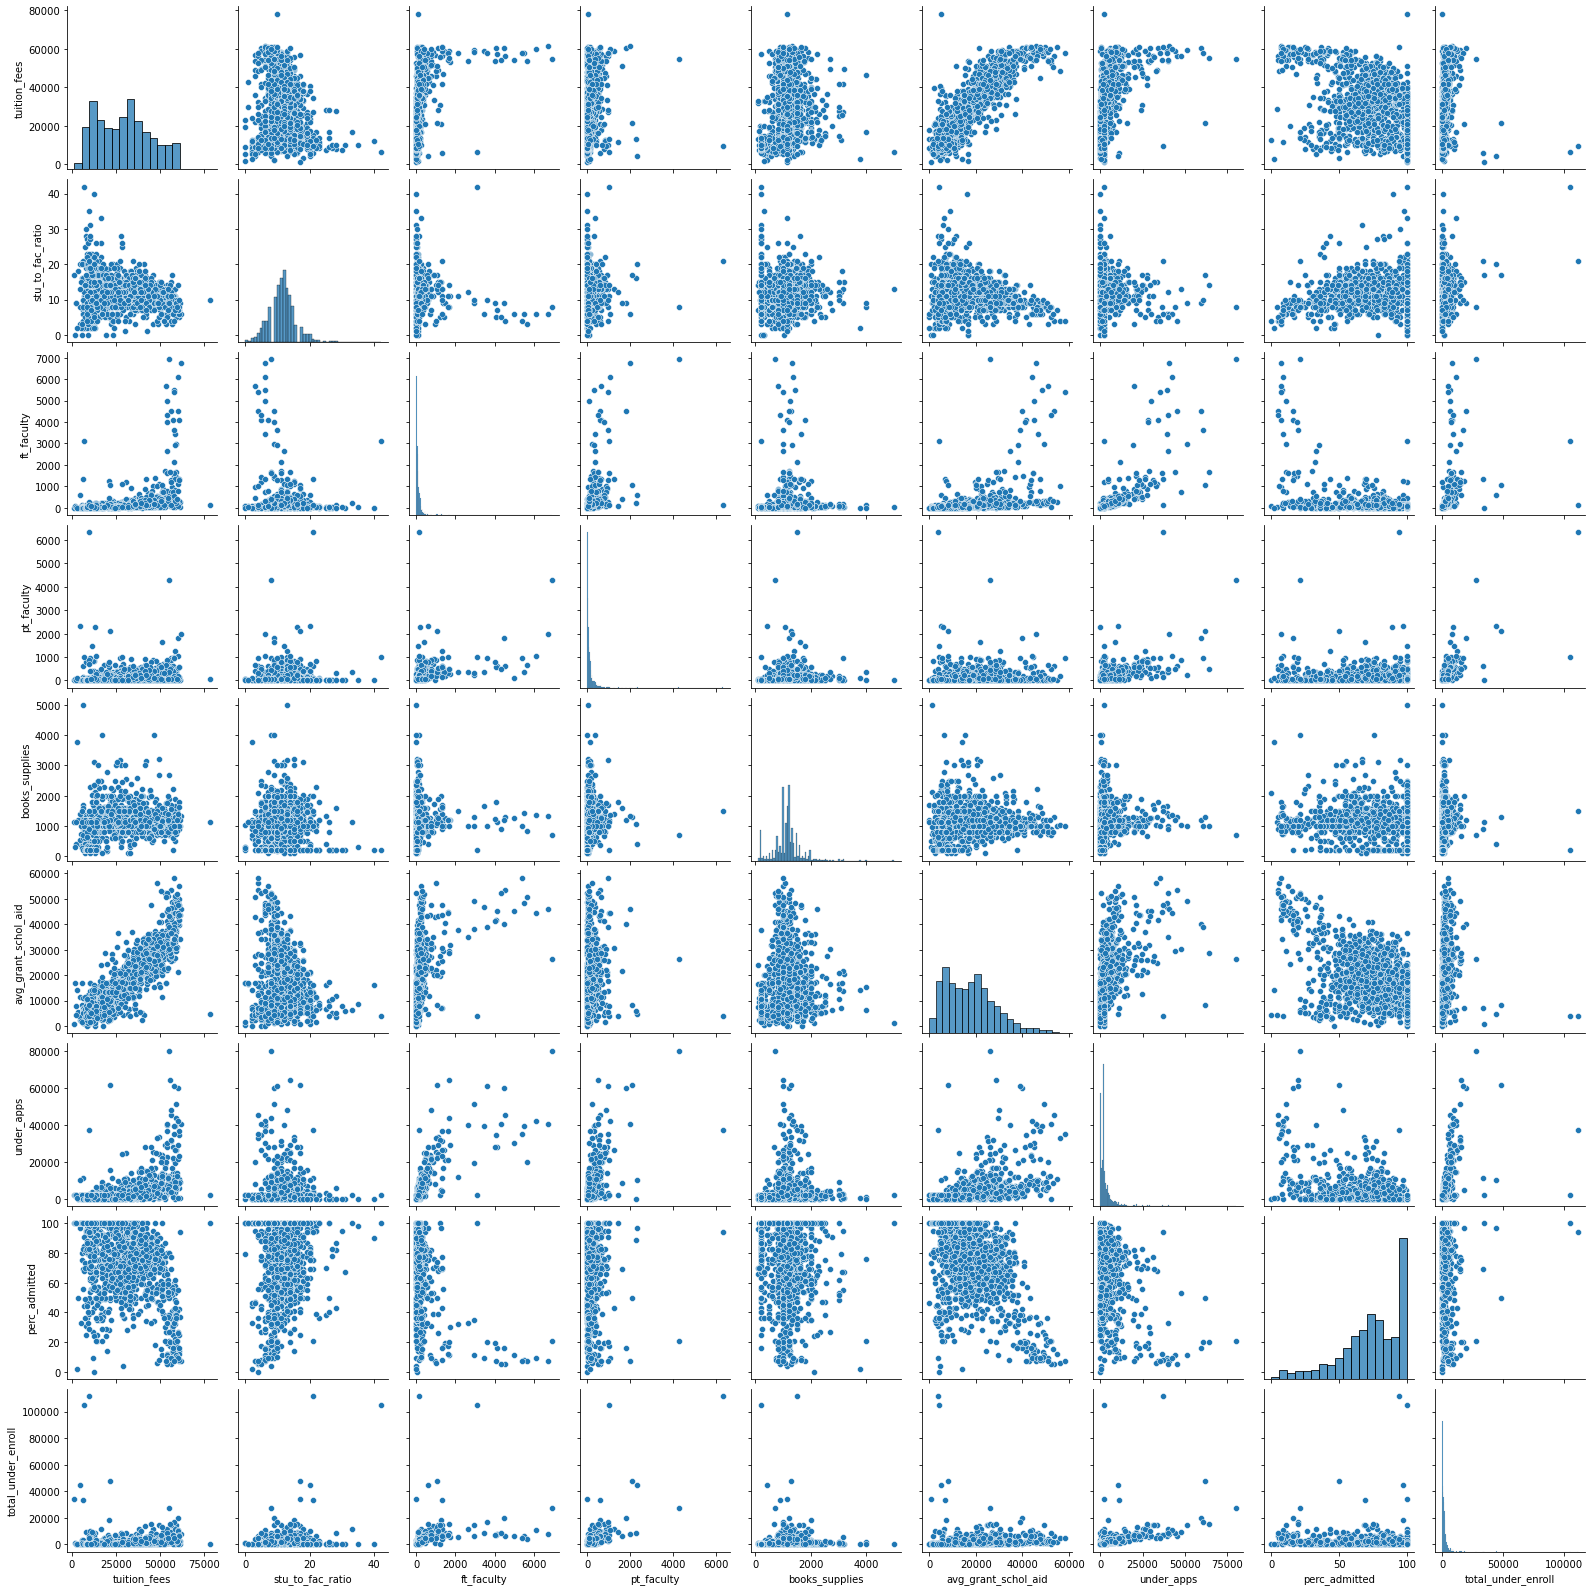

In [147]:
sns.pairplot(schools_df_rev, vars=['tuition_fees','stu_to_fac_ratio','ft_faculty','pt_faculty',
                                   'books_supplies','avg_grant_schol_aid','under_apps', 'perc_admitted',
                                   'total_under_enroll'])

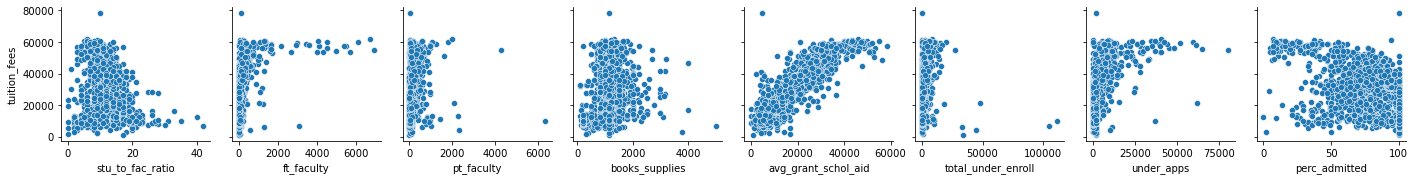

In [148]:
sns.pairplot(schools_df_rev, 
             y_vars=['tuition_fees'],
             x_vars=['stu_to_fac_ratio','ft_faculty','pt_faculty','books_supplies',
                     'avg_grant_schol_aid','total_under_enroll','under_apps', 'perc_admitted'])

#### Look at correlation between all feature variables and target variable

In [128]:
schools_df_rev.corr()

,tuition_fees,stu_to_fac_ratio,ft_faculty,pt_faculty,books_supplies,avg_grant_schol_aid,total_under_enroll,admiss_data_1,admiss_data_0,under_apps,perc_admitted,test_scores_req_0.0,test_scores_req_1.0,test_scores_rec_0.0,test_scores_rec_1.0,test_scores_con_not_req_0.0,test_scores_con_not_req_1.0
tuition_fees,1.000000,-0.127524,0.355115,0.180351,0.168017,0.868662,0.126083,0.419248,-0.419248,0.468527,-0.474228,-0.098822,0.098822,0.018853,-0.018853,-0.335606,0.335606
stu_to_fac_ratio,-0.127524,1.000000,-0.090214,0.096000,-0.033064,-0.128528,0.239377,0.082409,-0.082409,-0.032285,0.131749,-0.013300,0.013300,-0.019739,0.019739,0.019975,-0.019975
ft_faculty,0.355115,-0.090214,1.000000,0.461454,0.032513,0.393104,0.372525,0.112350,-0.112350,0.770360,-0.382017,-0.161580,0.161580,0.059014,-0.059014,-0.043072,0.043072
pt_faculty,0.180351,0.096000,0.461454,1.000000,0.087059,0.109195,0.724483,0.105107,-0.105107,0.561219,-0.103530,-0.072234,0.072234,0.031294,-0.031294,-0.054548,0.054548
books_supplies,0.168017,-0.033064,0.032513,0.087059,1.000000,0.053491,0.029005,0.058959,-0.058959,0.057543,-0.104113,-0.099511,0.099511,-0.029534,0.029534,-0.105152,0.105152
avg_grant_schol_aid,0.868662,-0.128528,0.393104,0.109195,0.053491,1.000000,0.094838,0.412129,-0.412129,0.453427,-0.527147,-0.122462,0.122462,0.023059,-0.023059,-0.302454,0.302454
total_under_enroll,0.126083,0.239377,0.372525,0.724483,0.029005,0.094838,1.000000,0.068949,-0.068949,0.484781,-0.087129,-0.065364,0.065364,0.026316,-0.026316,-0.034008,0.034008
admiss_data_1,0.419248,0.082409,0.112350,0.105107,0.058959,0.412129,0.068949,1.000000,-1.000000,0.129409,-0.525949,-0.251341,0.251341,-0.168307,0.168307,-0.322492,0.322492
admiss_data_0,-0.419248,-0.082409,-0.112350,-0.105107,-0.058959,-0.412129,-0.068949,-1.000000,1.000000,-0.129409,0.525949,0.251341,-0.251341,0.168307,-0.168307,0.322492,-0.322492
under_apps,0.468527,-0.032285,0.770360,0.561219,0.057543,0.453427,0.484781,0.129409,-0.129409,1.000000,-0.400589,-0.163090,0.163090,0.063527,-0.063527,-0.082592,0.082592


The only feature that is highly correlated with the target variable is avg_amt_grant_schol_aid_all_under_19_20 (the average amount of grant or scholarship aid received by undergrad students in 19-20, the most recent financial aid data available).

Also, the highest correlation between two feature variables is 0.724 (total undergrad enrollment and # of part-time faculty), so since it's not above 0.9, we don't need to remove any features

## Setting up for modeling and building a baseline

In [ ]:
import warnings

from   sklearn.linear_model    import LinearRegression
from   sklearn.model_selection import train_test_split
from   sklearn.metrics         import mean_squared_error

warnings.filterwarnings('ignore')

In [149]:
# Define features and target

X = schools_df_rev.loc[:,['avg_grant_schol_aid']]

y = schools_df_rev['tuition_fees']

In [150]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1323 entries, 0 to 131
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   avg_grant_schol_aid  1323 non-null   float64
dtypes: float64(1)
memory usage: 20.7 KB


#### Create a reusable function that repeatedly splits X, y into the same train/val partitions and fits/scores new models as I update my feature set

In [151]:
def split_and_validate(X, y, metric='rmse'):
    """For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results.
    """
    
    # Train and validation split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Score fit model on validation data
    if metric == "rmse":
        y_actual = y_val
        y_predicted = lr_model.predict(X_val)
        val_score = mean_squared_error(y_actual, y_predicted, squared=False)
    else:
        metric ="R²"
        val_score = lr_model.score(X_val, y_val)

    
    # Report results
    print("")
    print(f"Validation score for {metric}: {val_score:,.0f}")
    print("")
    print('Feature coefficient results:')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(f"{feature:<20}: {coef:>12,.0f}") 

#### Run the above function on the baseline feature set

In [152]:
split_and_validate(X, y)


Validation score for rmse: 7,968

Feature coefficient results:
avg_grant_schol_aid :            1


#### Notes: 
- If perc_grant_schol_aid_beg_under_19_20 > 100, it means it's capturing # of students, not %
- if avg_amt_grant_schol_aid_beg_under_19_20 == avg_amt_grant_schol_aid_all_under_19_20, it means there's only data for 'All Undergraduate Students'

- Further web-scraping of admissions-related data:
    - if presence of admissions data, collect the following:
        1. presence (1) or absence (0) of 'Admission test scores (SAT/ACT)' under 'Admissions considerations'
            - if presence of 'Admission test scores (SAT/ACT)', collect presence or absence of:
                1. required (1) or not (0)
                2. recommended (1) or not (0)
                3. considered but not required (1) or not (0)